# Make figures for DF project

* Number fluctuation at different bacterial concentration
20, 40, 60, 80 and 100 n$_0$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
from corrLib import boxsize_effect_spatial
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata

## Functions
* These functions will be collected in a library later

In [3]:
def readdata(folder):
    dataDirs = dirrec(folder, '*.csv')
    nameList = []
    dirList = []
    for dataDir in dataDirs:
        path, file = os.path.split(dataDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(dataDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList.Name = fileList.Name.astype('int32')
    fileList = fileList.sort_values(by=['Name'])
    return fileList

In [4]:
def average_NF(folder, avrange=[250, 500]):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        if i.Name < avrange[0] or i.Name > avrange[1]:
            continue
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

In [58]:
def corrlength(corrData, deg, fitting_range=1000):
    xx = np.array(corrData.R)
    yy = np.array(corrData.C)
    x = xx[xx<fitting_range]
    y = yy[xx<fitting_range]
    p = np.polyfit(x, y, deg)
    xsolve = np.linspace(0, x.max(), int(x.max()))
    yfit = np.dot(polyvander(xsolve, deg), np.flip(p).transpose())
    for xm, ym in zip(xsolve, yfit):
        if ym > (1 / np.e):
            continue
        else:
            return xm

## Figure implementations

#### Figure 1 - experiment
* Raw image from microscopy
* Spatial intensity variation

#### Figure 2 - GNF
* Deviation from CLT
* Slope vs. concentration

In [7]:
folders = [r'D:\Wei\Dynamics_raw\df_result\20',
           r'D:\Wei\Dynamics_raw\df_result\40',
           r'D:\Wei\Dynamics_raw\df_result\60',
           r'D:\Wei\Dynamics_raw\df_result\80',
           r'D:\Wei\Dynamics_raw\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[400, 1000])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

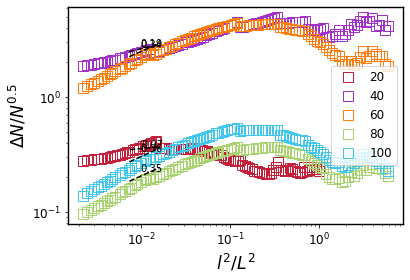

In [10]:
# GNF data
# Normalization of data is needed 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n/420**2
    yy = subdata.d/subdata.n**.5       
    plt.plot(xx, yy, label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[subdata.n<1e4]
    y = yy.loc[subdata.n<1e4] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/L^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

* Generate the data that are used in the plot

Text(0, 0.5, 'slope')

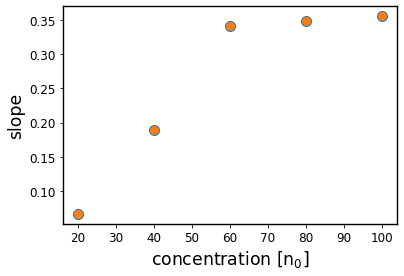

In [62]:
n = [20, 40, 60, 80, 100]
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

#### Figure 3 - intensity spatial correlation
* correlation vs. distance
* correlation length vs. concentration

In [28]:
# Average over 100 frames
folder = r'D:\Wei\Dynamics_raw\cl_result'
n = [20, 40, 60, 80, 100]
data = pd.DataFrame()
for nt in n:    
    subdata = average_NF(os.path.join(folder, str(nt)), avrange=[400, 1000])
    data = data.append(subdata.assign(conc=nt))

Text(0, 0.5, 'Correlation')

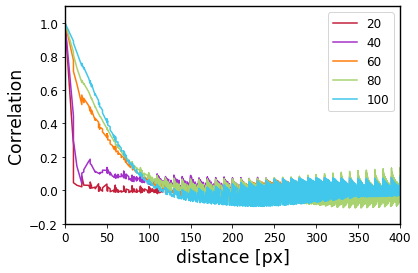

In [34]:
# Plot raw data
count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    plt.plot(subdata.R, subdata.C, color=wowcolor(count), label=str(nt))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'Correlation')

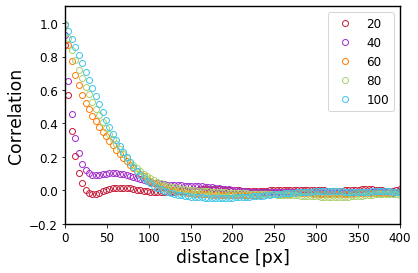

In [48]:
# Polynomial fitting in range
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'correlation')

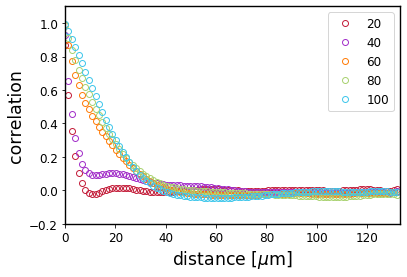

In [67]:
# Convert unit to um
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit*mpp, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 133, -0.2, 1.1])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('correlation')

Text(0, 0.5, 'correlation length [$\\mu$m]')

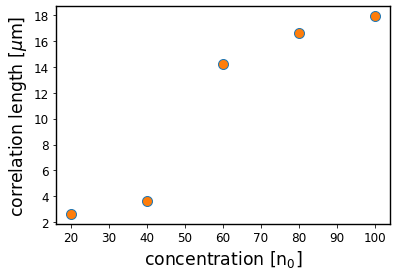

In [68]:
# Extract correlation length - based on polynomial fitting
deg = 8 # degree of polynomial fitting
sparcity = 1 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

n = [20, 40, 60, 80, 100]
cl = []
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl.append(corrlength(subdata, 10))
plt.plot(n, np.array(cl)*mpp, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('correlation length [$\mu$m]')

In [39]:
# Save data
# data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv', index=False)

#### Figure 4 - velocity and orientation spatial correlation
* velocity correlation 2D
* velocity correlation length vs. concentration
* orientation correlation 2D
* orientation correlation length vs. concentration

In [74]:
folder = r'D:\Wei\Dynamics_raw\piv_result\20'
pivData = pd.read_csv(os.path.join(folder, '0400-0401.csv'))
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
X = np.array(pivData.x).reshape((row, col))
Y = np.array(pivData.y).reshape((row, col))
U = np.array(pivData.u).reshape((row, col))
V = np.array(pivData.v).reshape((row, col))
CA, CV = corrS(X, Y, U, V)

1221
1184
1147
1110
1073
1036
999
962
925
888
851
814
777
740
703
666
629
592
555
518
481
444
407
370
333
296
259
222
185
148
111
74
37
1188
1152
1116
1080
1044
1008
972
936
900
864
828
792
756
720
684
648
612
576
540
504
468
432
396
360
324
288
252
216
180
144
108
72
36
1155
1120
1085
1050
1015
980
945
910
875
840
805
770
735
700
665
630
595
560
525
490
455
420
385
350
315
280
245
210
175
140
105
70
35
1122
1088
1054
1020
986
952
918
884
850
816
782
748
714
680
646
612
578
544
510
476
442
408
374
340
306
272
238
204
170
136
102
68
34
1089
1056
1023
990
957
924
891
858
825
792
759
726
693
660
627
594
561
528
495
462
429
396
363
330
297
264
231
198
165
132
99
66
33
1056
1024
992
960
928
896
864
832
800
768
736
704
672
640
608
576
544
512
480
448
416
384
352
320
288
256
224
192
160
128
96
64
32
1023
992
961
930
899
868
837
806
775
744
713
682
651
620
589
558
527
496
465
434
403
372
341
310
279
248
217
186
155
124
93
62
31
990
960
930
900
870
840
810
780
750
720
690
660
630
600
570
540
51

In [73]:
def corrS(X, Y, U, V):
    # X, Y, U, V represent a vector field
    # Return value C is a matrix representing spatial correlation distribution of given vector field
    row, col = X.shape
    vsq = 0
    CA = np.zeros((row, col))
    CV = np.zeros((row, col))
    for i in range(0, row):
        for j in  range(0, col):
            vsq += U[i, j]**2 + V[i, j]**2
    for xin in range(0, col):
        for yin in range(0, row):
            count = 0
            CAt = 0
            CVt = 0
            for i in range(0, col-xin):
                for j in range(0, row-yin):
                    ua = U[j, i]
                    va = V[j, i]
                    ub = U[j+yin, i+xin]
                    vb = V[j+yin, i+xin]
                    CAt += (ua*ub+va*vb)/((ua**2+va**2)*(ub**2+vb**2))**.5
                    CVt += ua*ub + va*vb
                    count += 1
            CA[yin, xin] = CAt / count
            
            CV[yin, xin] = CVt / vsq     
    return CA, CV

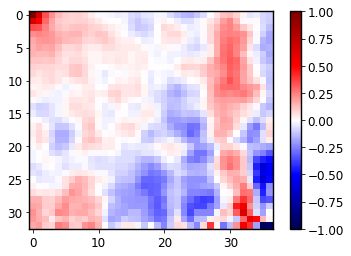

In [75]:
plt.imshow(CA, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()

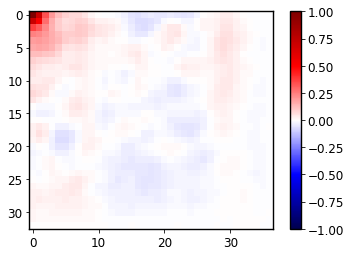

In [76]:
plt.imshow(CV, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()

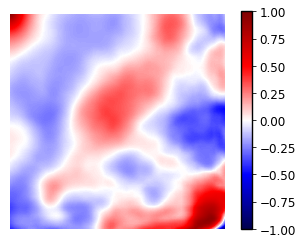

In [50]:
# Smooth correlation field
points = np.array([X.flatten(), Y.flatten()]).transpose()
values = np.array(CA.flatten())
xnew, ynew = np.mgrid[1:X.max(), 1:Y.max()]
smooth = griddata(points, values, (xnew, ynew), method='linear')
plt.imshow(smooth.transpose(), vmin=-1, vmax=1, cmap='seismic')
plt.axis('off')
plt.colorbar()

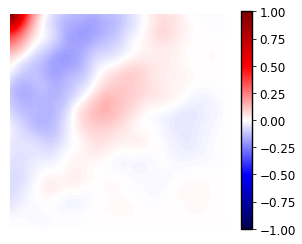

In [51]:
# Smooth correlation field
points = np.array([X.flatten(), Y.flatten()]).transpose()
values = np.array(CV.flatten())
xnew, ynew = np.mgrid[1:X.max(), 1:Y.max()]
smoothV = griddata(points, values, (xnew, ynew), method='linear')
plt.imshow(smoothV.transpose(), vmin=-1, vmax=1, cmap='seismic')
plt.axis('off')
plt.colorbar()

#### Figure 5 - what drives concentration fluctuations?
* concentration field $c$
* source field $\nabla \cdot (c\boldsymbol{n})$

In [55]:
x = np.linspace(0, 100, 100)

In [58]:
250/60

4.166666666666667